In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
FIGSIZE = (10, 8)

# [1] [A Gentle Stochastic Thermostat for Molecular Dynamics](https://doi.org/10.1007/s10955-009-9734-0)
## Ben Leimkuhler, Emad Noorizadeh, Florian Theil

In [80]:
def get_H(omega, m, beta):
    """Ref. [1], p. 271"""
    def H(q, p):
        return p**2/(2*m) + (omega**2)*(q**2)/2
    def dH(q):
        return omega**2 * q
    return H, dH

In [81]:
H, dH = get_H(omega=1, m=1, beta=1)

In [82]:
qs = np.linspace(-1, 1, 100)
ps = np.linspace(-1, 1, 100)
QS, PS = np.meshgrid(qs, ps)
E = H(QS, PS)

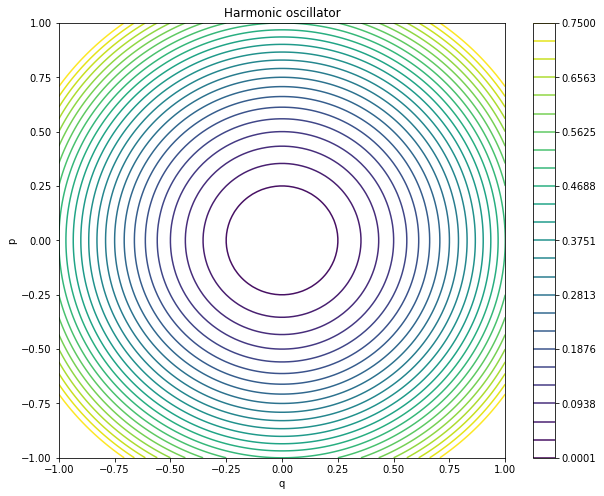

In [85]:
fig, ax = plt.subplots(figsize=FIGSIZE)

levels = np.linspace(E.min(), .75*E.max(), 25)
c = ax.contour(QS, PS, E, levels=levels)
ax.set_xlabel("q")
ax.set_ylabel("p")
ax.set_title("Harmonic oscillator")
fig.colorbar(c)

# Solve implicit linear equation for xi update

In [86]:
import sympy as sym
sym.init_printing()

In [87]:
x_n, x_np, dt, mu, T, s, W = sym.symbols(r"xi_n {\xi}_{n+1} {\Delta}t mu T sigma W")
x_n, x_np, dt, mu, T, s, W

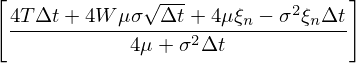

In [88]:
sym.solve(x_n + dt/mu * T + s*sym.sqrt(dt)* W - dt*s**2 / (4*mu) * (x_n + x_np) - x_np, x_np)

In [132]:
def integrate(omega, m, beta, p, q, dt, mu, sigma, max_cycles=1_000):
    H, dH =  get_H(omega, m, beta)
    xi = 0
    sqrt_dt = dt**0.5
    grad = dH(q)
    
    # Degrees of freedom
    N = 1
    
    qs = list()
    ps = list()
    for i in range(max_cycles):
        qs.append(q)
        ps.append(p)
        P = p - dt/2 * grad
        Q = q + dt/2 * P
        P = np.exp(-dt*xi / 2) * P
        
        sum_ = ((P**2)/m).sum() - N/beta
        W = np.random.rand(1) - 0.5
        xi = (4*sum_*dt + 4*W*mu*sigma*sqrt_dt + 4*mu*xi - sigma**2*xi*dt) / (4*mu + sigma**2 * dt)
        
        P = np.exp(-dt*xi / 2) * P
        # Update p, q
        q = Q + dt/2*P
        grad = dH(q)
        p = P - dt/2*grad
    return qs, ps

pq0 = 1
kwargs = {
    "omega": 1,
    "m": 1,
    "beta": 1.0,
    "p": pq0,
    "q": pq0,
    "dt": 0.01,
    "sigma": 5,
    "mu": 0.5,
    "max_cycles": 10_000,
}
# Example given in Section 4.1 of [1]
qs, ps = integrate(**kwargs)

qs = np.array(qs)
ps = np.array(ps)
def avg(arr):
    return np.cumsum(arr) / np.arange(1, arr.size + 1)
qs_avg = avg(qs)
ps_avg = avg(ps)

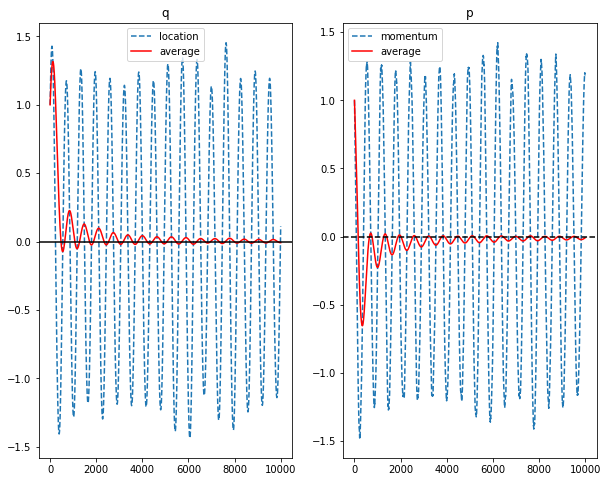

In [133]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=FIGSIZE)
ax0.plot(qs, ls="--", label="location")
ax0.plot(qs_avg, color="red", label="average")
ax0.axhline(0, color="k", )
ax0.set_title("q")
ax0.legend()

ax1.plot(ps, ls="--", label="momentum")
ax1.plot(ps_avg, color="red", label="average")
ax1.axhline(0, color="k", ls="--")
ax1.set_title("p")
ax1.legend()